# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* **Step 0**: Import Datasets
* **Step 1**: Detect Humans
* **Step 2**: Detect Dogs
* **Step 3**: Create a CNN to Classify Dog Breeds (from Scratch)
* **Step 4**: Use a CNN to Classify Dog Breeds (using Transfer Learning)
* **Step 5**: Create a CNN to Classify Dog Breeds (using Transfer Learning)
* **Step 6**: Write your Algorithm
* **Step 7**: Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

Using TensorFlow backend.
C:\Anaconda3\envs\dog-project\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 0


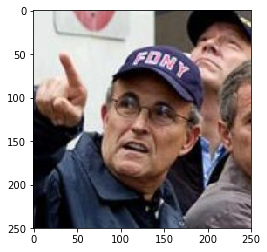

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[163])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
h_human = np.sum([face_detector(_) for _ in human_files_short])
h_dog = np.sum([face_detector(_) for _ in dog_files_short])
print("{} % of the first 100 images in human_files have a detected human face".format(h_human))
print("{} % of the first 100 images in dog_files have a detected human face".format(h_dog))

99 % of the first 100 images in human_files have a detected human face
11 % of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

Using one example below, we can see that the model (Haar feature-based cascade classifiers) is not always reliable for dectacting human faces. The model is great when provided with a clear view of the front of a face. However, when provided with half faces or side of faces, the model fails to detect them. We can train the model with blurred faces, half faces and side of faces. Other algorithms sources: OpenCV, OpenFace by Google, OpenBR

Number of faces detected: 0


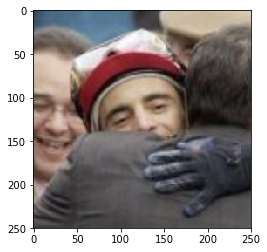

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

# For images that were "faceless" according to the model# For i 
for _ in range(916, 918):
    o_raw = cv2.imread(human_files[_])
    o_gray = cv2.cvtColor(o_raw, cv2.COLOR_BGR2GRAY)
    o_faces = face_cascade.detectMultiScale(o_gray)
    if len(o_faces) != 0:
        continue
    else:
        print('Number of faces detected:', len(o_faces))
        break

# convert BGR image to RGB for plotting
o_cv_rgb = cv2.cvtColor(o_raw, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(o_cv_rgb)
plt.show()

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
d_human = np.sum([dog_detector(_) for _ in human_files_short])
d_dog = np.sum([dog_detector(_) for _ in dog_files_short])
print("{0:0.1f} % of the images in human_files have a detected dog.".format(d_human))
print("{0:0.1f} % of the images in dog_files have a detected dog.".format(d_dog))

1.0 % of the images in human_files have a detected dog.
100.0 % of the images in dog_files have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:04<00:00, 168.03it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__
- **How many convolutional layers and why?**
 - I read about this [post](https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla) and found that the more convolutional layers the better the results (reasonably, because each convolutional layer reduces the number of input features to the fully connected layers). I did not want to add too many layers because the accuracy gain becomes insignificant after two or three layers. Also, I performed many trial and error tests.
- **How you decided the kernel size and strides?**
 - I started the convolutional layers with high filter number for high number of features. I want to make sure there are enough filters to identify the high number of dog breeds. I used kernel size 3x3 because it is usually the best practice for "scanning" through the array. I used strides=1 because I want to make sure the "scanner" can look thoroughly through each picture. I did not add padding for the edges of each pictures because all the dogs are centered nicely in each of the pictures. [Source](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)
- **Why the Max Pool layers?**
 - In the beginning, I explored batch normalization. I found the model trained fast in the beginning but could not surpass the accuracy of 8%. Also, the model took very long time to train (~135s per epoch). Then, I simplified the model by add max pooling layers after each convolutional layers with pool size of 2 and strides of 2 (also to reduce the number of parameters, or the training time). [Source](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)
- **What is the purpose of flatten layer?**
 - The flatten layer is implemented at the end of the convolutional neural network to convert the output into a one-dimensional feature vector. It "flattens" all its structure to create a single feature vector for the final classification. Also, before the flatten layer, I added a dropout layer to address overfitting by reduce the complexity of the model.
- **What are the dense layers doing, and how you decided the number of dense layers?**
 - Dense layers (fully-connected layers) transform the feature vector from the flatten layer to perform the final classification (e.g. to determine if there is a car in the image). I added two dense layers: one for classify features using "ReLU" and the last one using "softmax" (to regularize outputs to values between 0 and 1 as probabilities).
 
Also, I used dropout layers to prevent overfitting.

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', input_shape=train_tensors[0].shape))
model.add(MaxPooling2D(strides=2)) #default pool_size=2, padding='valid'

#model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPooling2D(strides=2))

#model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPooling2D(strides=2))

#model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPooling2D(strides=2))

#model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 256)       295168    
__________

### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping ##import earlystopping

epochs = 8

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20,
          callbacks=[early_stopping], ##stop when the val_loss is not improving
          verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/8
37s - loss: 4.8916 - acc: 0.0114 - val_loss: 4.6890 - val_acc: 0.0299
Epoch 2/8
36s - loss: 4.5230 - acc: 0.0413 - val_loss: 4.2801 - val_acc: 0.0527
Epoch 3/8
36s - loss: 4.1428 - acc: 0.0705 - val_loss: 4.2358 - val_acc: 0.0731
Epoch 4/8
36s - loss: 3.8324 - acc: 0.1265 - val_loss: 3.9569 - val_acc: 0.1018
Epoch 5/8
-14364s - loss: 3.4108 - acc: 0.1960 - val_loss: 3.8991 - val_acc: 0.1293
Epoch 6/8
36s - loss: 2.8745 - acc: 0.2912 - val_loss: 3.9290 - val_acc: 0.1269
Epoch 7/8
36s - loss: 2.3091 - acc: 0.4181 - val_loss: 4.0869 - val_acc: 0.1114
Epoch 8/8
36s - loss: 1.7600 - acc: 0.5404 - val_loss: 4.7497 - val_acc: 0.1401


### Load the Model with the Best Validation Loss

In [17]:
#model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# Since the model is using Early Stopping, there is no best model saved

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 14.3541%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=0, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[early_stopping], verbose=0)

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.7464%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

## All 4 models are implemented below

Additional resources on the networks: [https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/]

In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
def load_bottleneck_features(network_name):
    network_name = network_name
    path = 'bottleneck_features/Dog' + network_name + 'Data.npz'
    bottleneck_features = np.load(path)
    return bottleneck_features

#load the data
InceptionV3 = load_bottleneck_features('InceptionV3')
Resnet50 = load_bottleneck_features('Resnet50')
VGG19 = load_bottleneck_features('VGG19')
Xception = load_bottleneck_features('Xception')

#train, valid, test data
train_InceptionV3, valid_InceptionV3, test_InceptionV3 = InceptionV3['train'], InceptionV3['valid'], InceptionV3['test']
train_Resnet50, valid_Resnet50, test_Resnet50 = Resnet50['train'], Resnet50['valid'], Resnet50['test']
train_VGG19, valid_VGG19, test_VGG19 = VGG19['train'], VGG19['valid'], VGG19['test']
train_Xception, valid_Xception, test_Xception = Xception['train'], Xception['valid'], Xception['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
 - **Good case for transfer learning: **The data has been pre-trained using these networks and a perfect case for transfer learning. If to build a scratch CNN, not to say the training time will take weeks, the accuracy is also not guaranteed.
 - **Architectures: **At the final step of the CNN architecture, I implemented all 4 networks (InceptionV3, ResNet50, VGG19, and Xception). I wasn't sure which architecture is most suitable for the current problem. However, from this [blog](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/), I learned the strengths and drawbacks for each of them. I added a global average pooling layer at the beginning of the architecture to reduce the dimension of the output significantly. After that I added 2 fully connected layers with 1 dropout layer to implement final classification and to precent overfitting.
 - **Compare to VGG16 and scratch CNN: **The results are significantly better. Xception seems to be the best model.
  - InceptionV3 - Test accuracy: 81.4593%
  - Resnet50 - Test accuracy: 77.7512%
  - VGG19 - Test accuracy: 73.8038%
  - Xception - Test accuracy: 82.7751%

In [27]:
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(500, activation='relu'))
InceptionV3_model.add(Dropout(0.2))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               66633     
Total params: 1,091,133.0
Trainable params: 1,091,133.0
Non-trainable params: 0.0
_________________________________________________________________


In [28]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dropout(0.2))
Resnet50_model.add(Dense(500, activation='relu'))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dense_7 (Dense)              (None, 133)               66633     
Total params: 1,091,133.0
Trainable params: 1,091,133.0
Non-trainable params: 0.0
_________________________________________________________________


In [29]:
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dropout(0.2))
VGG19_model.add(Dense(500, activation='relu'))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               256500    
_________________________________________________________________
dense_9 (Dense)              (None, 133)               66633     
Total params: 323,133.0
Trainable params: 323,133.0
Non-trainable params: 0.0
_________________________________________________________________


In [30]:
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(500, activation='relu'))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               1024500   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 133)               66633     
Total params: 1,091,133.0
Trainable params: 1,091,133.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [31]:
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [32]:
#train_{network} = bottleneck_features['train']
#valid_{network} = bottleneck_features['valid']
#test_{network} = bottleneck_features['test']

In [33]:
InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=10, batch_size=20, callbacks=[early_stopping], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
3s - loss: 1.5488 - acc: 0.6367 - val_loss: 0.9306 - val_acc: 0.7317
Epoch 2/10
2s - loss: 0.7394 - acc: 0.7918 - val_loss: 0.7896 - val_acc: 0.7916
Epoch 3/10
2s - loss: 0.5989 - acc: 0.8304 - val_loss: 0.7373 - val_acc: 0.8240
Epoch 4/10
2s - loss: 0.5113 - acc: 0.8530 - val_loss: 0.8001 - val_acc: 0.8120
Epoch 5/10
2s - loss: 0.4572 - acc: 0.8744 - val_loss: 0.8981 - val_acc: 0.8072
Epoch 6/10
2s - loss: 0.3983 - acc: 0.8891 - val_loss: 0.8299 - val_acc: 0.8240
Epoch 7/10
2s - loss: 0.3491 - acc: 0.9021 - val_loss: 0.8434 - val_acc: 0.8323
Epoch 8/10
2s - loss: 0.3324 - acc: 0.9060 - val_loss: 0.9570 - val_acc: 0.8251
Epoch 9/10
2s - loss: 0.2947 - acc: 0.9192 - val_loss: 0.8928 - val_acc: 0.8371


In [34]:
Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=10, batch_size=20, callbacks=[early_stopping], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
1s - loss: 1.8234 - acc: 0.5487 - val_loss: 0.9050 - val_acc: 0.7150
Epoch 2/10
1s - loss: 0.6446 - acc: 0.8027 - val_loss: 0.9353 - val_acc: 0.7341
Epoch 3/10
1s - loss: 0.4249 - acc: 0.8672 - val_loss: 0.9386 - val_acc: 0.7509
Epoch 4/10
1s - loss: 0.2985 - acc: 0.9030 - val_loss: 0.8052 - val_acc: 0.8060
Epoch 5/10
1s - loss: 0.2428 - acc: 0.9268 - val_loss: 0.8800 - val_acc: 0.7952
Epoch 6/10
1s - loss: 0.2024 - acc: 0.9358 - val_loss: 0.8854 - val_acc: 0.8036
Epoch 7/10
1s - loss: 0.1758 - acc: 0.9476 - val_loss: 1.1175 - val_acc: 0.7892
Epoch 8/10
1s - loss: 0.1412 - acc: 0.9569 - val_loss: 1.0360 - val_acc: 0.7976
Epoch 9/10
1s - loss: 0.1288 - acc: 0.9603 - val_loss: 1.1337 - val_acc: 0.7976
Epoch 10/10
1s - loss: 0.1142 - acc: 0.9662 - val_loss: 1.3002 - val_acc: 0.7892


In [35]:
VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=10, batch_size=20, callbacks=[early_stopping], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
2s - loss: 4.7855 - acc: 0.3133 - val_loss: 1.4937 - val_acc: 0.5940
Epoch 2/10
1s - loss: 1.3780 - acc: 0.6446 - val_loss: 1.2040 - val_acc: 0.6946
Epoch 3/10
1s - loss: 1.0829 - acc: 0.7157 - val_loss: 1.0887 - val_acc: 0.7018
Epoch 4/10
1s - loss: 0.8838 - acc: 0.7738 - val_loss: 1.2509 - val_acc: 0.7042
Epoch 5/10
1s - loss: 0.7824 - acc: 0.8009 - val_loss: 1.2457 - val_acc: 0.7257
Epoch 6/10
1s - loss: 0.7563 - acc: 0.8144 - val_loss: 1.3374 - val_acc: 0.7162
Epoch 7/10
1s - loss: 0.6760 - acc: 0.8364 - val_loss: 1.2689 - val_acc: 0.7449
Epoch 8/10
1s - loss: 0.6135 - acc: 0.8519 - val_loss: 1.3769 - val_acc: 0.7605
Epoch 9/10
1s - loss: 0.5816 - acc: 0.8657 - val_loss: 1.5148 - val_acc: 0.7234


In [36]:
Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=10, batch_size=20, callbacks=[early_stopping], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
4s - loss: 1.2731 - acc: 0.6805 - val_loss: 0.6281 - val_acc: 0.7988
Epoch 2/10
3s - loss: 0.5525 - acc: 0.8302 - val_loss: 0.6376 - val_acc: 0.8108
Epoch 3/10
3s - loss: 0.4131 - acc: 0.8669 - val_loss: 0.6836 - val_acc: 0.8144
Epoch 4/10
3s - loss: 0.3280 - acc: 0.8940 - val_loss: 0.6405 - val_acc: 0.8263
Epoch 5/10
3s - loss: 0.2695 - acc: 0.9171 - val_loss: 0.7151 - val_acc: 0.8168
Epoch 6/10
3s - loss: 0.2272 - acc: 0.9278 - val_loss: 0.7495 - val_acc: 0.8263
Epoch 7/10
3s - loss: 0.1990 - acc: 0.9365 - val_loss: 0.8186 - val_acc: 0.8383


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [37]:
### TODO: Load the model weights with the best validation loss.   --- Early Stopping are used instead
#InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')
#Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')
#VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')
#Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [38]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy_InceptionV3 = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
test_accuracy_Resnet50 = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
test_accuracy_VGG19 = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
test_accuracy_Xception = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)

In [39]:
print('InceptionV3 - Test accuracy: %.4f%%' % test_accuracy_InceptionV3)
print('Resnet50 - Test accuracy: %.4f%%' % test_accuracy_Resnet50)
print('VGG19 - Test accuracy: %.4f%%' % test_accuracy_VGG19)
print('Xception - Test accuracy: %.4f%%' % test_accuracy_Xception)

InceptionV3 - Test accuracy: 81.4593%
Resnet50 - Test accuracy: 77.7512%
VGG19 - Test accuracy: 73.8038%
Xception - Test accuracy: 82.7751%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [40]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

"""Since Xception is the best model, I will use Xception to predict dog breeds"""

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return top-3 most probable dog breeds that are predicted by the model
    indices = predicted_vector[0].argsort()[-3:][::-1]
    names = [dog_names[i] for i in indices]
    probabilities = [round(100 * predicted_vector[0][i], 4) for i in indices]
    return names, probabilities

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [41]:
# dog_or_human algorithm
def dogs_or_humans(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    plt.imshow(img/280)
    plt.show()
    if dog_detector(img_path):
        print('Dog detected!\n\n Wolf! You are a\n\n')
        dogs, percents = Xception_predict_breed(img_path)
        d = zip(dogs, percents)
        for keys, items in enumerate(d):
            print(keys, items)
    elif face_detector(img_path):
        print('Hello there!\n\n If you were a dog, you look like a\n\n')
        names, percents = Xception_predict_breed(img_path)
        d = zip(names, percents)
        for keys, items in enumerate(d):
            print(keys, items)
    else:
        print('Sorry, I cannot recognize you.')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The results below show that the algorithm does a pretty good job classifying dog breeds and identify humans. I used 6 human pictures (the last two: one is distorted by fists and the other one is cartoon). The algorithm recognizes 4 out of 6. Out of these 4 recognized people, the algorithm gives its best guess on the dog breeds but low probabilities (much lower than the actual dog pictures at the end). I also used a cat picture and another cartoon dog picture just to try. Well, the algorithm does not like cartoons. For the four actual dog pictures at the end, the algorithm does a fantastic job classifying 3 of their breeds - except for the doberman dog, which is extremely similar to a manchester terrier.

There are many ways to improve:
 - With the limited input training data, we may "augument" the training data by pre-processing the data. We can rescale, resize, flip, or even apply shear transformation to the samples ([keras.preprocessing.image.ImageDataGenerator](https://keras.io/preprocessing/image/)).
 - Another approach is to tune the top layers of a pre-trained network. "Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. Fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp."[source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 - Overfitting can be significant when train the model. The main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better. There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.[source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)



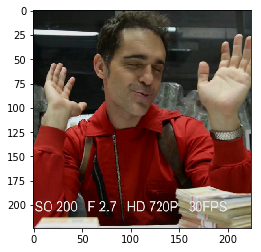

Hello there!

 If you were a dog, you look like a


0 ('Basset_hound', 21.2908)
1 ('Pomeranian', 11.8079)
2 ('Dachshund', 8.8114)


In [42]:
dogs_or_humans('dogs_or_humans\Berlin.jpg')

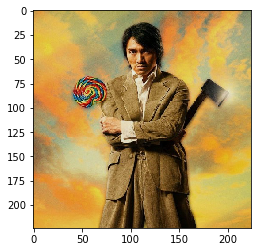

Hello there!

 If you were a dog, you look like a


0 ('Petit_basset_griffon_vendeen', 21.4571)
1 ('Glen_of_imaal_terrier', 20.293)
2 ('Chinese_crested', 15.3871)


In [43]:
dogs_or_humans('dogs_or_humans\hustle.jpg')

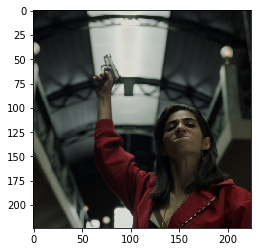

Hello there!

 If you were a dog, you look like a


0 ('Dachshund', 65.0552)
1 ('Greyhound', 9.6813)
2 ('Lhasa_apso', 6.2822)


In [44]:
dogs_or_humans('dogs_or_humans\_n.jpg')

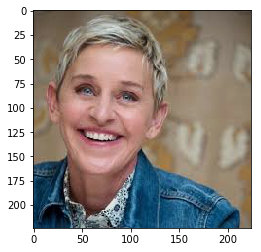

Hello there!

 If you were a dog, you look like a


0 ('Glen_of_imaal_terrier', 43.4301)
1 ('Dachshund', 23.1088)
2 ('Petit_basset_griffon_vendeen', 4.2003)


In [45]:
dogs_or_humans('dogs_or_humans\Ellen_DeGeneres_1.jpg')

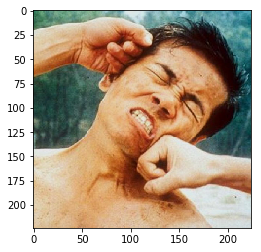

Sorry, I cannot recognize you.


In [46]:
dogs_or_humans('dogs_or_humans\shaolin-soccer.jpg')

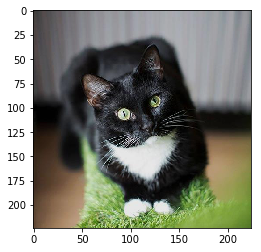

Sorry, I cannot recognize you.


In [47]:
dogs_or_humans('dogs_or_humans\cat_1.jpg')

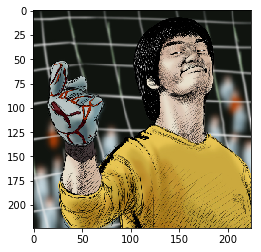

Sorry, I cannot recognize you.


In [48]:
dogs_or_humans('dogs_or_humans\BruceLee.jpg')

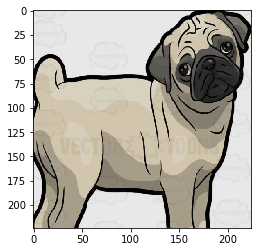

Sorry, I cannot recognize you.


In [49]:
dogs_or_humans('dogs_or_humans\pug_c.jpg')

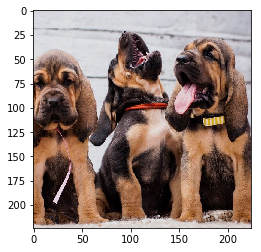

Dog detected!

 Wolf! You are a


0 ('Bloodhound', 99.9959)
1 ('Mastiff', 0.0037)
2 ('Neapolitan_mastiff', 0.0002)


In [50]:
dogs_or_humans('dogs_or_humans\Bloodhound.jpg')

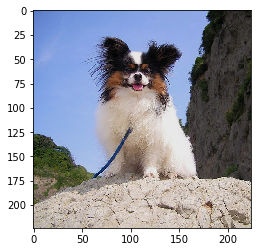

Dog detected!

 Wolf! You are a


0 ('Papillon', 100.0)
1 ('Chinese_crested', 0.0)
2 ('Chihuahua', 0.0)


In [51]:
dogs_or_humans('dogs_or_humans\papillon.jpg')

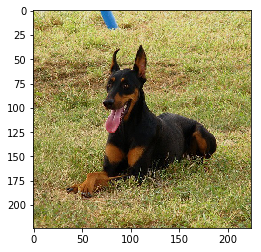

Dog detected!

 Wolf! You are a


0 ('Manchester_terrier', 99.7322)
1 ('Dachshund', 0.1161)
2 ('German_pinscher', 0.1115)


In [52]:
dogs_or_humans('dogs_or_humans\doberman.jpg')

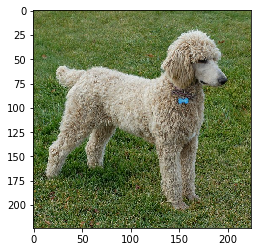

Dog detected!

 Wolf! You are a


0 ('Poodle', 100.0)
1 ('Portuguese_water_dog', 0.0)
2 ('Bichon_frise', 0.0)


In [53]:
dogs_or_humans('dogs_or_humans\poodle.jpg')